<a id='top'></a><a name='top'></a>
# Chapter 14: Transformer Positional Encoding Layer in Keras


* [Introduction](#introduction)
* [14.0 Imports and Setup](#14.0)
* [14.1 What is Positional Encoding](#14.1)
* [14.2 Positional Encoding Layer in Transformers](#14.2)
* [14.3 Coding the Positional Encoding Matrix from Scratch](#14.3)
* [14.4 Positional Encoding in Transformers](#14.4)
* [14.5 Visualizing the Final Embedding](#14.5)
* [Extra](#extra)

---
<a name='introduction'></a><a id='introduction'></a>
# Introduction
<a href="#top">[back to top]</a>

Implement the positional encoding layer in Keras and TensorFlow.

### Dataset

* Toy dataset.

### Explore
* Text vectorization in Keras
* Embedding layer in Keras
* How to subclass the embedding layer and write your own positional encoding layer

---
<a name='14.0'></a><a id='14.0'></a>
# 14.0 Imports and Setup
<a href="#top">[back to top]</a>

In [1]:
req_file = "requirements_14.txt"

In [3]:
%%writefile {req_file}
isort
scikit-learn-intelex
watermark

Overwriting requirements_14.txt


In [4]:
import sys
IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    print("Installing packages")
    !pip install --upgrade --quiet -r {req_file}
else:
    print("Running locally.")

# Need to import before sklearn
from sklearnex import patch_sklearn
patch_sklearn()

Running locally.


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
%%writefile imports.py
import locale
import math
import pprint
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import convert_to_tensor
from tensorflow.data import Dataset
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import TextVectorization
from tqdm.auto import tqdm
from watermark import watermark

Overwriting imports.py


In [4]:
!isort imports.py --sl
!cat imports.py

import locale
import math
import pprint
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import convert_to_tensor
from tensorflow.data import Dataset
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import TextVectorization
from tqdm.auto import tqdm
from watermark import watermark


In [5]:
import locale
import math
import pprint
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import convert_to_tensor
from tensorflow.data import Dataset
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import TextVectorization
from tqdm.auto import tqdm
from watermark import watermark

In [6]:
def HR():
    print("-"*40)
    
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
warnings.filterwarnings('default')
BASE_DIR = '.'
sns.set_style("darkgrid")
tqdm.pandas(desc="progress-bar")
pp = pprint.PrettyPrinter(indent=4)

seed = 42

print(watermark(iversions=True,globals_=globals(),python=True,machine=True))

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.34.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.3)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

numpy     : 1.23.5
pandas    : 1.5.3
seaborn   : 0.12.1
tensorflow: 2.9.3
matplotlib: 3.6.2



---
<a name='14.1'></a><a id='14.1'></a>
# 14.1 The Text Vectorization Layer
<a href="#top">[back to top]</a>

The following uses the `adapt` method to generate a vocabulary. It then creates a vectorized representation of the text

In [7]:
# Toy dataset source
output_sequence_length = 5
vocab_size = 10

sentences = [["I am a robot"], ["you too robot"]]
sentence_data = Dataset.from_tensor_slices(sentences)

print(sentences)
HR()
pp.pprint(sentence_data.__dict__)

[['I am a robot'], ['you too robot']]
----------------------------------------
{   '_graph_attr': <tensorflow.python.framework.ops.Graph object at 0x1342fb4f0>,
    '_name': None,
    '_options_attr': <tensorflow.python.data.ops.options.Options object at 0x10ca1d1f0>,
    '_structure': TensorSpec(shape=(1,), dtype=tf.string, name=None),
    '_tensors': [   <tf.Tensor: shape=(2, 1), dtype=string, numpy=
array([[b'I am a robot'],
       [b'you too robot']], dtype=object)>],
    '_variant_tensor_attr': <tf.Tensor: shape=(), dtype=variant, value=<TensorSliceDatasetOp::Dataset>>}


2023-06-18 18:46:51.718682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# See for reference:
# https://www.tensorflow.org/text/guide/word_embeddings

# Create the TextVectorization layer
# A preprocessing layer which maps text features to integer sequences.
vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=output_sequence_length
)

# Train the layer to create a dictionary
vectorize_layer.adapt(sentence_data)

vectorize_layer

In [9]:
# Convert all sentences to tensors
word_tensors = convert_to_tensor(sentences, dtype=tf.string)

# Use the word tensors to get vectorized phrases
vectorized_words = vectorize_layer(word_tensors)


print(f"word_tensors:\n{word_tensors}") # Tensor
HR() 
print(f"Vocabulary:\n{vectorize_layer.get_vocabulary()}") # TextVectorization
HR()
print(f"Vectorized words:\n{vectorized_words}") # Tensor

word_tensors:
[[b'I am a robot']
 [b'you too robot']]
----------------------------------------
Vocabulary:
['', '[UNK]', 'robot', 'you', 'too', 'i', 'am', 'a']
----------------------------------------
Vectorized words:
[[5 6 7 2 0]
 [3 4 2 0 0]]


---
<a name='14.2'></a><a id='14.2'></a>
# 14.2 The Embedding Layer
<a href="#top">[back to top]</a>

The Keras `Embedding` layer converts integers to dense vectors. This layer maps these integers to random numbers, which are later tuned during the training phase. 

We also have the option to set the mapping to some predefined weight values. To initialize this layer, you need to specify the maximum value of an integer to map, along with the length of the output sequence.

See for reference:
* https://www.tensorflow.org/text/guide/word_embeddings
* https://www.tensorflow.org/tutorials/text/warmstart_embedding_matrix


#### The Word Embeddings

The Keras `Embedding` layer converts `vectorized_text` to tensors.

In [10]:
tf.random.set_seed(seed)

output_length = 6

print(vocab_size)
print(output_length)
HR()

word_embedding_layer = Embedding(
    vocab_size, 
    output_length, 
    name="embedding"
)

embedded_words = word_embedding_layer(vectorized_words)

print(embedded_words.numpy().round(4))

10
6
----------------------------------------
[[[ 0.0449 -0.0262  0.0312  0.0026 -0.0006 -0.0284]
  [ 0.0346  0.0372 -0.0192  0.0187 -0.0262  0.0282]
  [ 0.0467 -0.0431  0.0299  0.016   0.0087 -0.0335]
  [-0.0367  0.0048  0.0075  0.04   -0.0491  0.0021]
  [ 0.0165 -0.0059 -0.0147 -0.0036 -0.0466  0.0185]]

 [[ 0.0135 -0.0301  0.0229  0.0046 -0.0392  0.0177]
  [ 0.016  -0.0163  0.0101 -0.0289  0.0353 -0.0059]
  [-0.0367  0.0048  0.0075  0.04   -0.0491  0.0021]
  [ 0.0165 -0.0059 -0.0147 -0.0036 -0.0466  0.0185]
  [ 0.0165 -0.0059 -0.0147 -0.0036 -0.0466  0.0185]]]


In [11]:
print(f"I \t{embedded_words[0][0]}")
HR()
print(f"am \t{embedded_words[0][1]}")
HR()
print(f"a \t{embedded_words[0][2]}")
HR()
print(f"robot \t{embedded_words[0][3]}")

I 	[ 0.04485276 -0.02624741  0.0311793   0.00263394 -0.0005692  -0.02838715]
----------------------------------------
am 	[ 0.03457197  0.03718841 -0.01916138  0.01868038 -0.02623596  0.02817228]
----------------------------------------
a 	[ 0.04671384 -0.04312984  0.02987394  0.01602871  0.00871513 -0.0335383 ]
----------------------------------------
robot 	[-0.03668128  0.00480639  0.00746088  0.03996835 -0.04905364  0.00212307]


In [12]:
print(f"you \t{embedded_words[1][0]}")
HR()
print(f"too \t{embedded_words[1][1]}")
HR()
print(f"robot \t{embedded_words[1][2]}")

you 	[ 0.01345445 -0.03006717  0.02294225  0.00458346 -0.03924345  0.01767061]
----------------------------------------
too 	[ 0.01602763 -0.01630496  0.01014177 -0.02893742  0.03527372 -0.00593783]
----------------------------------------
robot 	[-0.03668128  0.00480639  0.00746088  0.03996835 -0.04905364  0.00212307]


---
#### Position Embeddings

We also need the embeddings for the corresponding positions. The maximum positions correspond to the output sequence length of the `TextVectorization` layer.

In [13]:
# Maximum positions correspond to output_sequence length
output_sequence_length

5

In [14]:
tf.random.set_seed(seed)

position_embedding_layer = Embedding(output_sequence_length, output_length)
position_indices = tf.range(output_sequence_length)
embedded_indices = position_embedding_layer(position_indices)

print(embedded_indices.numpy().round(6))

[[ 0.016456 -0.005899 -0.014712 -0.003552 -0.046634  0.018467]
 [ 0.024012  0.037244 -0.027367 -0.02768  -0.018961  0.022234]
 [-0.036681  0.004806  0.007461  0.039968 -0.049054  0.002123]
 [ 0.013454 -0.030067  0.022942  0.004583 -0.039243  0.017671]
 [ 0.016028 -0.016305  0.010142 -0.028937  0.035274 -0.005938]]


In [15]:
for i, x in enumerate(embedded_indices):
    print(f"Index {i}: {x.numpy().round(6)}")

Index 0: [ 0.016456 -0.005899 -0.014712 -0.003552 -0.046634  0.018467]
Index 1: [ 0.024012  0.037244 -0.027367 -0.02768  -0.018961  0.022234]
Index 2: [-0.036681  0.004806  0.007461  0.039968 -0.049054  0.002123]
Index 3: [ 0.013454 -0.030067  0.022942  0.004583 -0.039243  0.017671]
Index 4: [ 0.016028 -0.016305  0.010142 -0.028937  0.035274 -0.005938]


#### The Output of Positional Encoding Layer in Transformers

In a transformer model, the final output is the sum of both the word embeddings and the position embeddings. 

When you set up both embedding layers, you need to make sure the `output_length` is the same for both.


In [16]:
final_output_embedding = embedded_words + embedded_indices

print(final_output_embedding.numpy().round(6))

[[[ 0.061309 -0.032147  0.016468 -0.000918 -0.047203 -0.00992 ]
  [ 0.058584  0.074433 -0.046529 -0.009    -0.045197  0.050406]
  [ 0.010033 -0.038323  0.037335  0.055997 -0.040339 -0.031415]
  [-0.023227 -0.025261  0.030403  0.044552 -0.088297  0.019794]
  [ 0.032484 -0.022204 -0.00457  -0.032489 -0.01136   0.012529]]

 [[ 0.029911 -0.035966  0.00823   0.001032 -0.085877  0.036138]
  [ 0.040039  0.020939 -0.017226 -0.056618  0.016313  0.016296]
  [-0.073363  0.009613  0.014922  0.079937 -0.098107  0.004246]
  [ 0.029911 -0.035966  0.00823   0.001032 -0.085877  0.036138]
  [ 0.032484 -0.022204 -0.00457  -0.032489 -0.01136   0.012529]]]


---
<a name='14.3'></a><a id='14.3'></a>
# 14.3 Subclassing the Keras Embedding Layer
<a href="#top">[back to top]</a>

When implementing a transformer model, you have to write your own position encoding layer. 

This is straightforward, as the basic functionality is already provided. 

**Note**

This class creates an embedding layer that is trainable weights. Hence the weights are initialized randomly and tuned in the training phase. 

In [25]:
class PositionEmbeddingLayer(Layer):
    def __init__(self, seq_length, vocab_size, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.word_embedding_layer = Embedding(
            input_dim = vocab_size,
            output_dim = output_dim
        )
        self.position_embedding_layer = Embedding(
            input_dim = seq_length,
            output_dim = output_dim
        )
    
    def call(self, inputs):
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

In [43]:
tf.random.set_seed(seed)

print(output_sequence_length, vocab_size, output_length)
HR()

# Run this layer
my_embedding_layer = PositionEmbeddingLayer(
    output_sequence_length,
    vocab_size,
    output_length
)

embedded_layer_output = my_embedding_layer(vectorized_words)

print(f"Output from my_embedded_layer:\n\n{embedded_layer_output.numpy().round(6)}")

5 10 6
----------------------------------------
Output from my_embedded_layer:

[[[ 0.063642 -0.0278    0.074279 -0.022147  0.022546  0.01087 ]
  [ 0.079247  0.062122 -0.034236  0.023399 -0.050076  0.047907]
  [ 0.008676 -0.039645  0.051364  0.05353  -0.007317 -0.066161]
  [-0.042496  0.044889 -0.028735  0.002186 -0.041509  0.046295]
  [ 0.058322  0.003809 -0.003617  0.028535 -0.013364  0.057626]]

 [[ 0.032244 -0.031619  0.066042 -0.020198 -0.016128  0.056927]
  [ 0.060702  0.008628 -0.004933 -0.024219  0.011434  0.013797]
  [-0.074719  0.008291  0.028951  0.07747  -0.065086 -0.030499]
  [ 0.010641  0.034183 -0.050908 -0.041334 -0.039089  0.062639]
  [ 0.058322  0.003809 -0.003617  0.028535 -0.013364  0.057626]]]


---
<a name='14.4'></a><a id='14.4'></a>
# 14.4 Positional Encoding in Transformers
<a href="#top">[back to top]</a>

* Unlike the above, this positional encoding does not have trainable weights.
* Instead, this uses a sin/cos positional encoding scheme.

In [44]:
class PositionEmbeddingFixedWeights(Layer):
    def __init__(self, seq_length, vocab_size, output_dim, **kwargs):
        super().__init__(**kwargs)
        word_embedding_matrix = self.get_position_encoding(vocab_size, output_dim)
        pos_embedding_matrix = self.get_position_encoding(seq_length, output_dim)
    self.word_embedding_layer = Embedding(
            input_dim=vocab_size, output_dim=output_dim,
            weights=[word_embedding_matrix],
            trainable=False
        )
        self.position_embedding_layer = Embedding(
            input_dim=seq_length, output_dim=output_dim,
            weights=[pos_embedding_matrix],
            trainable=False
        )

    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P


    def call(self, inputs):
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

In [45]:
tf.random.set_seed(seed)

attnisallyouneed_embedding = PositionEmbeddingFixedWeights(
    output_sequence_length,
    vocab_size, 
    output_length
)

attnisallyouneed_output = attnisallyouneed_embedding(vectorized_words)

print(attnisallyouneed_output.numpy().round(6))

[[[-0.958924  1.283662  0.230002  1.97319   0.010772  1.999942]
  [ 0.562055  1.500472  0.321308  1.960393  0.015081  1.999914]
  [ 1.566284  0.337755  0.411923  1.943373  0.019389  1.999877]
  [ 1.050417 -1.406139  0.231497  1.986015  0.010772  1.99997 ]
  [-0.756802  0.346356  0.184599  1.982814  0.008618  1.999963]]

 [[ 0.14112   0.010008  0.138798  1.990321  0.006463  1.999979]
  [ 0.084668 -0.113341  0.230998  1.981737  0.010772  1.99996 ]
  [ 1.818595 -0.832294  0.185397  1.991388  0.008618  1.999981]
  [ 0.14112   0.010008  0.138798  1.990321  0.006463  1.999979]
  [-0.756802  0.346356  0.184599  1.982814  0.008618  1.999963]]]


---
<a name='14.5'></a><a id='14.5'></a>
# 14.5 Visualizing the Final Embedding
<a href="#top">[back to top]</a>

In [62]:
technical_phrase = "to understand machine learning algorithms you need" +\
                   " to understand concepts such as gradient of a function "+\
                   "Hessians of a matrix and optimization etc"

wise_phrase = "patrick henry said give me liberty or give me death "+\
              "when he addressed the second virginia convention in march"

total_vocabulary = 200
seq_length = 20
final_output_len = 50

tf.random.set_seed(seed)

phrase_vectorization_layer = TextVectorization(
    output_sequence_length = seq_length,
    max_tokens = total_vocabulary
)

# Learn the dictionary
phrase_vectorization_layer.adapt([technical_phrase, wise_phrase])

# Convert all sentences to tensors
phrase_tensors = convert_to_tensor([technical_phrase, wise_phrase], dtype=tf.string)

# Use the word tensors to get vectorized phrases
vectorized_phrases = phrase_vectorization_layer(phrase_tensors)

random_weights_embedding_layer = PositionEmbeddingLayer(
    seq_length,
    total_vocabulary,
    final_output_len
)

fixed_weights_embedding_layer = PositionEmbeddingFixedWeights(
    seq_length,
    total_vocabulary,
    final_output_len
)

random_embedding = random_weights_embedding_layer(vectorized_phrases)

fixed_embedding = fixed_weights_embedding_layer(vectorized_phrases)

In [63]:
print(random_embedding.shape)
print(fixed_embedding.shape)

(2, 20, 50)
(2, 20, 50)


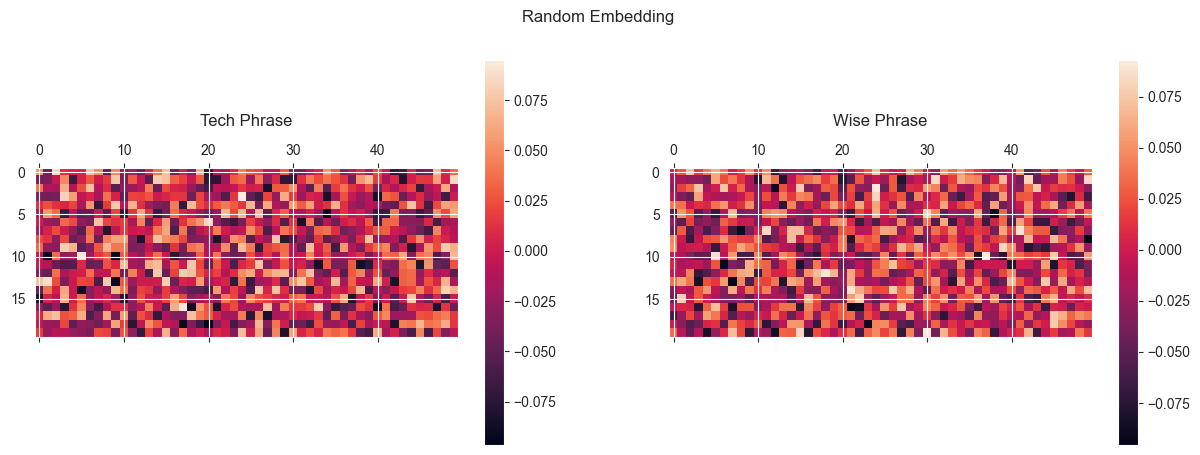

In [64]:
fig = plt.figure(figsize=(15, 5))
title = ["Tech Phrase", "Wise Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(random_embedding[i, :, :], (seq_length, final_output_len))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)
    plt.title(title[i], y=1.2)
fig.suptitle("Random Embedding")
plt.show()

### Embeddings from fixed weights layer

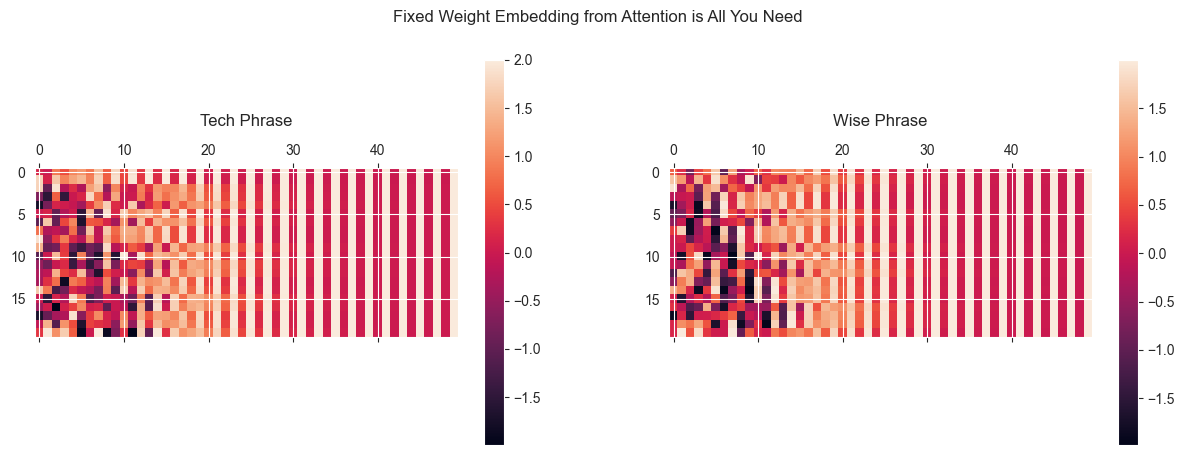

In [65]:
fig = plt.figure(figsize=(15, 5))
title = ["Tech Phrase", "Wise Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(fixed_embedding[i, :, :], (seq_length, final_output_len))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)
    plt.title(title[i], y=1.2)
fig.suptitle("Fixed Weight Embedding from Attention is All You Need")
plt.show()